# CNN + ELM para classificação

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import scipy

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

# Receptive field Conv1d ELM

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.linalg import pinv  # Penrose inverse


class CELMModel1d(nn.Module):
    def __init__(self, n_channels, n_classes, hidden_layer_size, reg_constant=None):
        super(CELMModel1d, self).__init__()

        # Camada conv
        self.rf8 = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=8),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.rf16 = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.rf32 = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.rf64 = nn.Sequential(
            nn.Conv1d(n_channels, 32, kernel_size=64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )

        # Set false para evitar treinar
        for param in self.rf8.parameters():
            param.requires_grad = False
        for param in self.rf16.parameters():
            param.requires_grad = False
        for param in self.rf32.parameters():
            param.requires_grad = False
        for param in self.rf64.parameters():
            param.requires_grad = False

        # ELM
        self.features_size = 312
        self.elm_hidden_layer_size = hidden_layer_size

        self.elm_input_weights = nn.Parameter(
            torch.empty(
                self.features_size, self.elm_hidden_layer_size
            ),  # Num de features x Num neuronios da elm
            requires_grad=False,
        )
        self.elm_input_bias = nn.Parameter(
            torch.zeros(self.elm_hidden_layer_size),
            requires_grad=False,
        )
        self.elm_activation = nn.Sigmoid()

        # Inicia com zerio pois vai preencher no treino
        self.elm_output_weights = nn.Parameter(
            torch.zeros(self.elm_hidden_layer_size, n_classes), requires_grad=False
        )

        self._initialize_weights()

        self.reg_constant = reg_constant

    def _initialize_weights(self):
        # Init
        for layer in self.cnn:
            if isinstance(layer, nn.Conv1d):
                nn.init.orthogonal_(
                    layer.weight,
                )
                if layer.bias is not None:
                    nn.init.normal_(layer.bias)

        # Init input layer
        nn.init.orthogonal_(self.elm_input_weights)
        nn.init.normal_(self.elm_input_bias)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)

        # ELM hidden layer
        H = self.elm_activation(
            torch.mm(x, self.elm_input_weights) + self.elm_input_bias
        )

        # ELM output layer
        output = torch.mm(H, self.elm_output_weights)
        return F.softmax(output, dim=1)

    def train_elm(self, train_loader, n_classes, device=0):
        # self.eval()  # Tira do odo de treino para nao treinar as camadas da cnn
        H_list, y_list = [], []

        with torch.no_grad():
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Extrai features, flatten e passa pra gpu
                # Esse é a entrada x da elm
                features = self.cnn(inputs).view(inputs.size(0), -1).to(device)

                # Matriz H pra cada vetor de entradas (features)
                # o resultado dessa multiplicação de matrizes é um vetor linha
                # cada elemento i é h_i(wx + b), onde i o neuronio i da camada profunda
                H = self.elm_activation(
                    torch.mm(features, self.elm_input_weights) + self.elm_input_bias
                )

                H_list.append(H)
                y_list.append(F.one_hot(labels, num_classes=n_classes).float())

        # "Empilha" as linhas para montar H e y
        H_full = torch.cat(H_list, dim=0)
        Y_full = torch.cat(y_list, dim=0)

        if self.reg_constant is None:
            # https://pytorch.org/docs/stable/generated/torch.linalg.pinv.html
            # torch.linalg.lstsq(A, B).solution == pinv(A) @ B
            self.elm_output_weights.data = torch.linalg.lstsq(H_full, Y_full).solution
        else:
            # Regularização
            I = torch.eye(H_full.shape[1]).to(device)
            H_reg = torch.mm(H_full.t(), H_full) + (I / self.reg_constant)
            HY = torch.mm(H_full.t(), Y_full)

            # https://pytorch.org/docs/stable/generated/torch.linalg.pinv.html
            # torch.linalg.lstsq(A, B).solution == pinv(A) @ B
            self.elm_output_weights.data = torch.linalg.lstsq(H_reg, HY).solution

In [16]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


def plot_confusion_matrix(all_labels, all_preds, class_labels):
    # Compute the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    # Create a figure and increase the figure size
    plt.figure()
    # Create a heatmap using seaborn
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2g",
        cmap="Blues",
        xticklabels=class_labels,
        yticklabels=class_labels,
        square=True,
    )
    # Set labels and title
    plt.xlabel("Predicted", fontsize=14, fontweight="bold")
    plt.ylabel("True", fontsize=14, fontweight="bold")
    plt.title("Confusion Matrix", fontsize=16, fontweight="bold")
    # Increase font size of annotations
    plt.tick_params(labelsize=12)
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


def evaluate_elm(model, test_loader, device=0):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)

            # Predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average="weighted")
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(all_labels, all_preds, class_labels=["8", "10", "12", "15"])

    print(f"Test set Accuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Confusion Matrix:\n{cm}")

    return accuracy, recall, f1

In [7]:
windows = np.load(
    "datasets/sinais_filtrados_6_52_Hz_janelas_1s/S1_passa-banda_6_52_Hz_janelas.npy"
)
windows.shape

(64, 250, 40, 6, 5)

In [8]:
frequencias_fases = scipy.io.loadmat("Freq_Phase.mat")
frequencias = np.round(
    frequencias_fases["freqs"], 2
)  # Frequências de estimulação, arredondadas
fases = frequencias_fases["phases"]  # Fases associadas às frequências

freq_selecionadas = np.array([8, 10, 12, 15])  # Frequências de interesse
channels = [
    47,
    53,
    54,
    55,
    56,
    57,
    60,
    61,
    62,
]  #  Pz, PO5, PO3, POz, PO4, PO6, O1, Oz, O2

channel_Oz = 61
labels = []
signals = []
for trial in range(0, 6):
    labels_trial = []
    signals_trial = []
    for idx, freq in enumerate(freq_selecionadas):
        for window in range(0, 5):
            signal = windows[
                channels, :, np.where(frequencias == freq)[1], trial, window
            ]
            signals_trial.append(signal)
            labels_trial.append(idx)
    labels.append(labels_trial)
    signals.append(signals_trial)

signals = np.array(signals)
labels = np.array(labels)
print(signals.shape)
print(labels.shape)

(6, 20, 9, 250)
(6, 20)


In [9]:
reshaped_data = signals.reshape(-1, signals.shape[-1])

In [10]:
reshaped_data.shape

(1080, 250)

In [11]:
from sklearn.preprocessing import MinMaxScaler


def split_train_test_trials(X, y, test_trial):
    y_test = []
    y_train = []
    X_test = []
    X_train = []

    X_shape = X.shape
    X_reshaped = X.reshape(-1, X.shape[-1])
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_transformed = scaler.fit_transform(X_reshaped.T).T  # normaliza entre 0 e 1
    X_transformed = X_transformed.reshape(X_shape)

    for trial in range(0, 6):
        if trial == test_trial:
            X_test.extend(X_transformed[trial])
            y_test.extend(y[trial])
        else:
            X_train.extend(X_transformed[trial])
            y_train.extend(y[trial])
    return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)


def prepare_data(X, y, test_trial=5, train_batch_size=16, test_batch_size=1):
    X_train, X_test, y_train, y_test = split_train_test_trials(X, y, test_trial)
    train_data = TensorDataset(
        torch.tensor(X_train, dtype=torch.float32).to(device),
        torch.tensor(y_train, dtype=torch.long).to(device),
    )
    test_data = TensorDataset(
        torch.tensor(X_test, dtype=torch.float32).to(device),
        torch.tensor(y_test, dtype=torch.long).to(device),
    )
    train_loader = DataLoader(train_data, batch_size=train_batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=test_batch_size, shuffle=True)
    return train_loader, test_loader

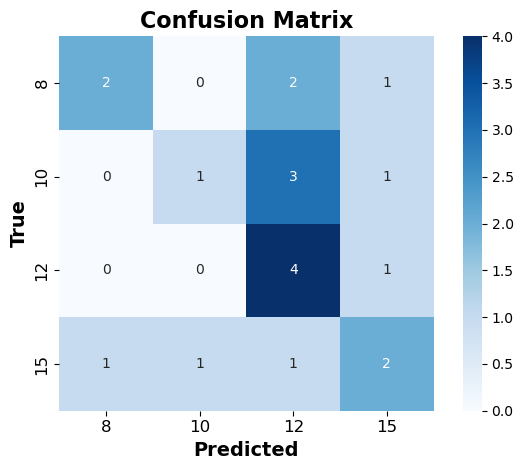

Test set Accuracy: 0.4500
Recall: 0.4500
F1 Score: 0.4298
Confusion Matrix:
[[2 0 2 1]
 [0 1 3 1]
 [0 0 4 1]
 [1 1 1 2]]


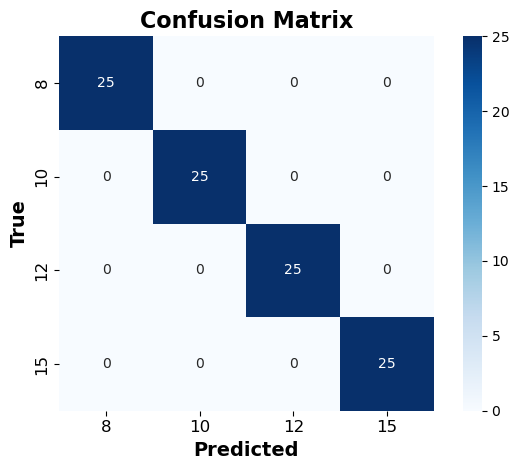

Test set Accuracy: 1.0000
Recall: 1.0000
F1 Score: 1.0000
Confusion Matrix:
[[25  0  0  0]
 [ 0 25  0  0]
 [ 0  0 25  0]
 [ 0  0  0 25]]


(1.0, 1.0, 1.0)

In [18]:
# Initialize model
n_channels = 9  # Number of input channels
elm_hidden_units = 1000  # Number of ELM hidden units
n_classes = 4  # Number of output classes
model = CELMModel1d(n_channels, n_classes, elm_hidden_units, None).to(device)

train_loader, test_loader = prepare_data(
    signals, labels, test_trial=4, train_batch_size=100
)

# Train ELM output weights
model.train_elm(train_loader, n_classes)

# Evaluate on test set
evaluate_elm(model, test_loader, device=0)
evaluate_elm(model, train_loader, device=0)